In [1]:
import pandas as pd
import numpy as np
import math
import requests
import acquire as a
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pprint import pprint
from vega_datasets import data
%matplotlib inline
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm


# plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)

In [2]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import username, password, host
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 


In [4]:
df = a.acquire_store()
df.head(3)

,sale_date,sale_amount,item_brand,item_name,item_price,store_address,store_zipcode
0,2013-01-01,13,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253
1,2013-01-02,11,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253
2,2013-01-03,14,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253


In [6]:
df = a.prep_store_data(df)
df.head()

,quantity,item_brand,item_name,item_price,store_address,store_zipcode,sales_total
sale_date,,,,,,,
2013-01-01,13,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,10.92
2013-01-01,26,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,12018 Perrin Beitel Rd,78217,218.40
2013-01-01,27,Mama Marys,Pizza Sauce,4.65,12018 Perrin Beitel Rd,78217,125.55
2013-01-01,54,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,15000 San Pedro Ave,78232,453.60
2013-01-01,35,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,735 SW Military Dr,78221,294.00


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   quantity       913000 non-null  int64  
 1   item_brand     913000 non-null  object 
 2   item_name      913000 non-null  object 
 3   item_price     913000 non-null  float64
 4   store_address  913000 non-null  object 
 5   store_zipcode  913000 non-null  int64  
 6   sales_total    913000 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 55.7+ MB


In [8]:
df.describe()


,quantity,item_price,store_zipcode,sales_total
count,913000.000000,913000.000000,913000.000000,913000.000000
mean,52.250287,5.160400,78224.800000,280.898866
std,28.801144,2.737764,16.479087,227.686575
min,0.000000,0.600000,78201.000000,0.000000
25%,30.000000,2.970000,78217.000000,98.010000
50%,47.000000,5.195000,78220.500000,233.280000
75%,70.000000,7.520000,78232.000000,402.780000
max,231.000000,9.640000,78253.000000,2104.410000


In [9]:
df_resampled = df.resample('d')[['quantity','sales_total']].sum()

# Drop February 29th from our dataset (a leap year date)
df_resampled = df_resampled[df_resampled.index != '2016-02-29']

df_resampled.head()


,quantity,sales_total
sale_date,,
2013-01-01,13696,73844.01
2013-01-02,13678,73570.58
2013-01-03,14488,78169.48
2013-01-04,15677,84467.73
2013-01-05,16237,87621.85


In [10]:
train_size = int(len(df_resampled) * .5)
validate_size = int(len(df_resampled) * .3)
test_size = int(len(df_resampled) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df_resampled[: train_size]
validate = df_resampled[train_size : validate_end_index]
test = df_resampled[validate_end_index : ]


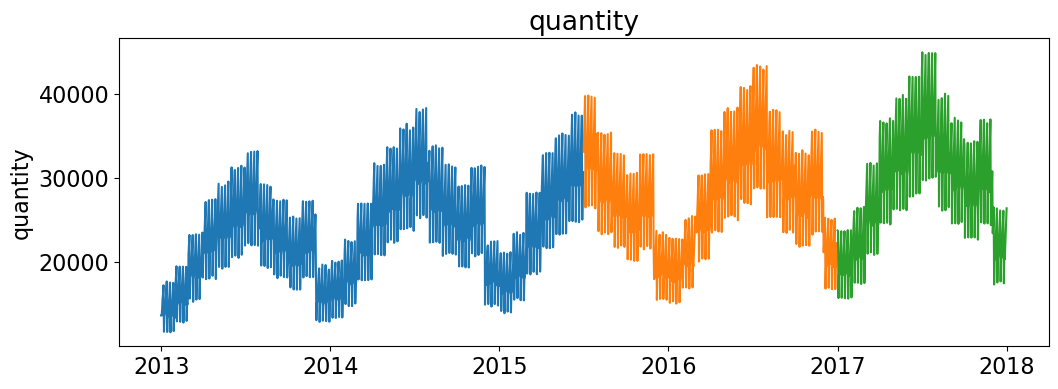

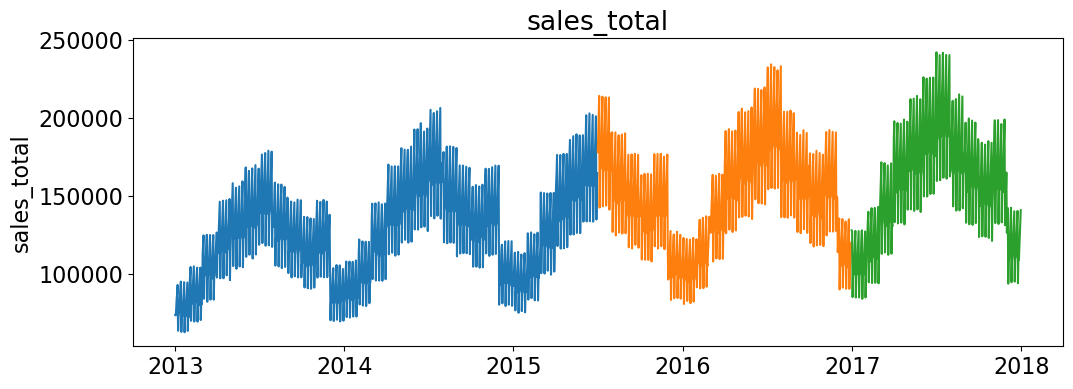

In [11]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()


In [12]:
# evaluation function to compute rmse
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


In [13]:
# plot and evaluate 
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()


In [14]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df


,model_type,target_var,rmse


In [15]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return pd.concat([eval_df, d])


In [16]:
# take the last item of sales total and assign to variable
last_sales = train['sales_total'][-1:][0]

# take the last item of quantity and assign to variable
last_quantity = train['quantity'][-1:][0]

yhat_df = pd.DataFrame(
    {'sales_total': [last_sales],
     'quantity': [last_quantity]},
    index=validate.index)

yhat_df.head()


,sales_total,quantity
sale_date,,
2015-07-02,164573.2,30703
2015-07-03,164573.2,30703
2015-07-04,164573.2,30703
2015-07-05,164573.2,30703
2015-07-06,164573.2,30703


quantity -- RMSE: 6621


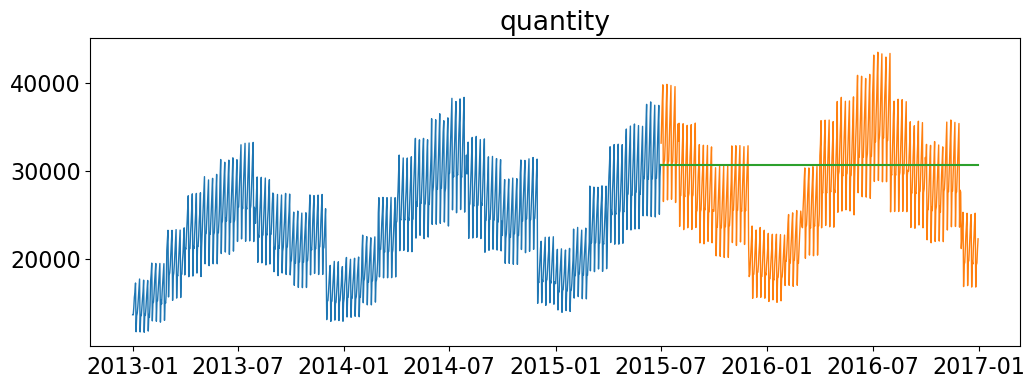

sales_total -- RMSE: 35402


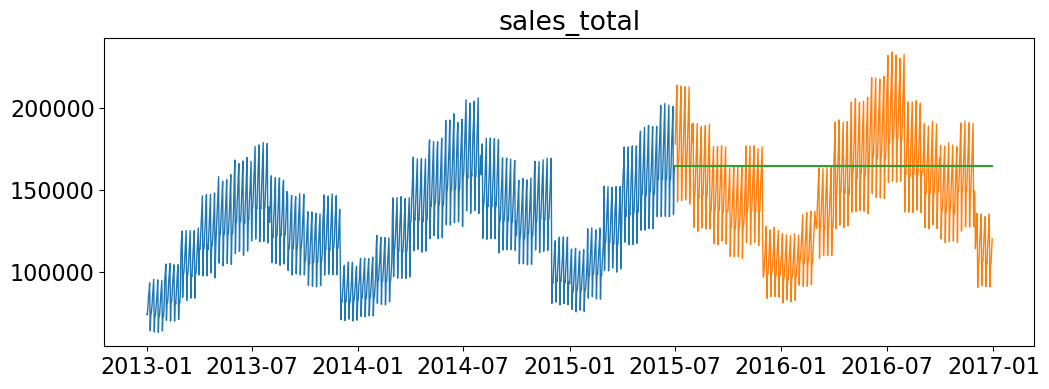

In [17]:
for col in train.columns:
    plot_and_eval(col)


In [18]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)


In [19]:
eval_df


,model_type,target_var,rmse
0,last_observed_value,quantity,6621.0
0,last_observed_value,sales_total,35402.0


In [20]:
# compute simple average of sales_total (from train data)
avg_sales = round(train['sales_total'].mean(), 2)

# compute simple average of quantity (from train data)
avg_quantity = round(train['quantity'].mean(), 2)


yhat_df = pd.DataFrame({'sales_total': [avg_sales],
                        'quantity': [avg_quantity]},
                        index=validate.index)

yhat_df.head(3)


,sales_total,quantity
sale_date,,
2015-07-02,127517.85,23717.94
2015-07-03,127517.85,23717.94
2015-07-04,127517.85,23717.94


quantity -- RMSE: 7378


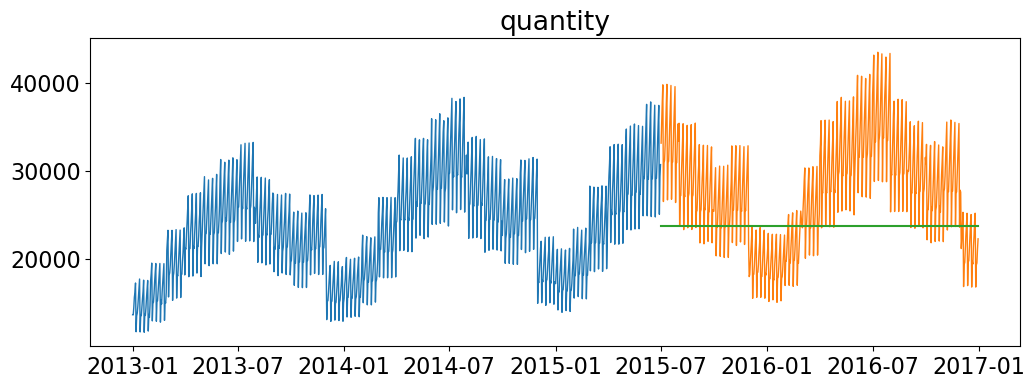

sales_total -- RMSE: 39664


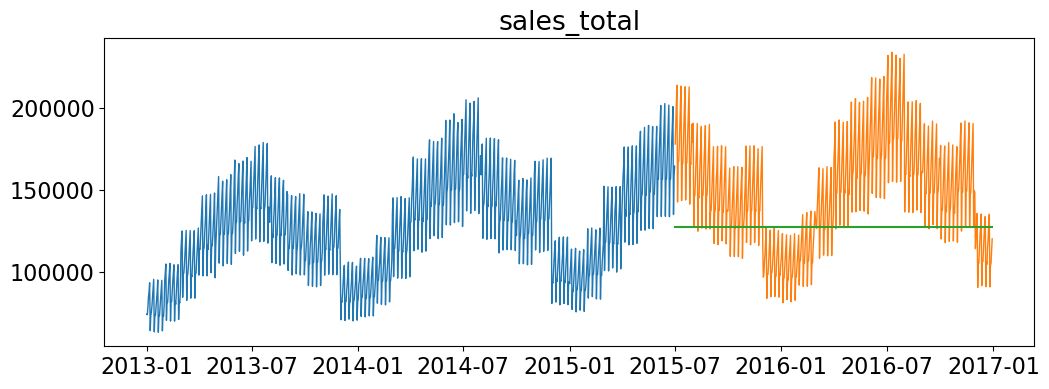

In [21]:
for col in train.columns:
    plot_and_eval(col)


In [23]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
eval_df


,model_type,target_var,rmse
0,last_observed_value,quantity,6621.0
0,last_observed_value,sales_total,35402.0
0,simple_average,quantity,7378.0
0,simple_average,sales_total,39664.0


In [24]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30

rolling_sales = round(train['sales_total'].rolling(period).mean()[-1], 2)
rolling_quantity = round(train['quantity'].rolling(period).mean()[-1], 2)

# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'sales_total': rolling_sales,
                        'quantity': rolling_quantity},
                         index=validate.index)
yhat_df.head()


,sales_total,quantity
sale_date,,
2015-07-02,168957.91,31432.77
2015-07-03,168957.91,31432.77
2015-07-04,168957.91,31432.77
2015-07-05,168957.91,31432.77
2015-07-06,168957.91,31432.77


quantity -- RMSE: 6954


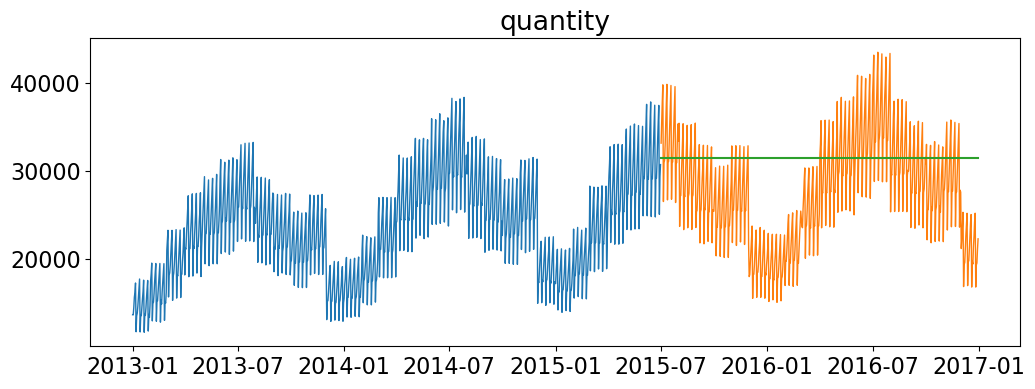

sales_total -- RMSE: 37378


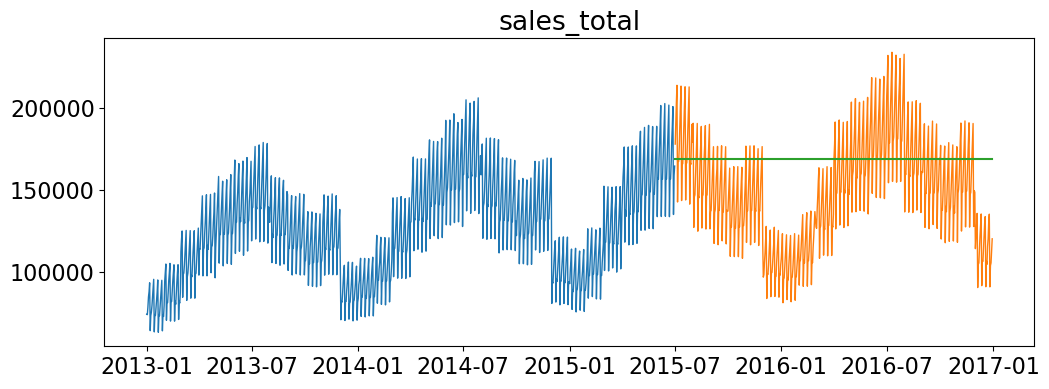

In [25]:
for col in train.columns:
    plot_and_eval(col)


In [26]:
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)
eval_df


,model_type,target_var,rmse
0,last_observed_value,quantity,6621.0
0,last_observed_value,sales_total,35402.0
0,simple_average,quantity,7378.0
0,simple_average,sales_total,39664.0
0,30d moving average,quantity,6954.0
0,30d moving average,sales_total,37378.0


In [27]:
periods = [4, 12, 26, 52, 104]

for p in periods: 
    rolling_sales = round(train['sales_total'].rolling(p).mean()[-1], 2)
    rolling_quantity = round(train['quantity'].rolling(p).mean()[-1], 2)
    yhat_df = pd.DataFrame({'sales_total': rolling_sales,
                            'quantity': rolling_quantity},
                            index=validate.index)
    model_type = str(p) + '_day_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)


In [28]:
eval_df


,model_type,target_var,rmse
0,last_observed_value,quantity,6621.0
0,last_observed_value,sales_total,35402.0
0,simple_average,quantity,7378.0
0,simple_average,sales_total,39664.0
0,30d moving average,quantity,6954.0
0,30d moving average,sales_total,37378.0
0,4_day_moving_avg,quantity,6592.0
0,4_day_moving_avg,sales_total,35515.0
0,12_day_moving_avg,quantity,6992.0
0,12_day_moving_avg,sales_total,37644.0


In [29]:
# get the min rmse for each variable

min_rmse_sales_total = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_quantity = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_sales_total) | 
         (eval_df.rmse == min_rmse_quantity)
        )]


,model_type,target_var,rmse
0,104_day_moving_avg,quantity,6101.0
0,104_day_moving_avg,sales_total,32803.0


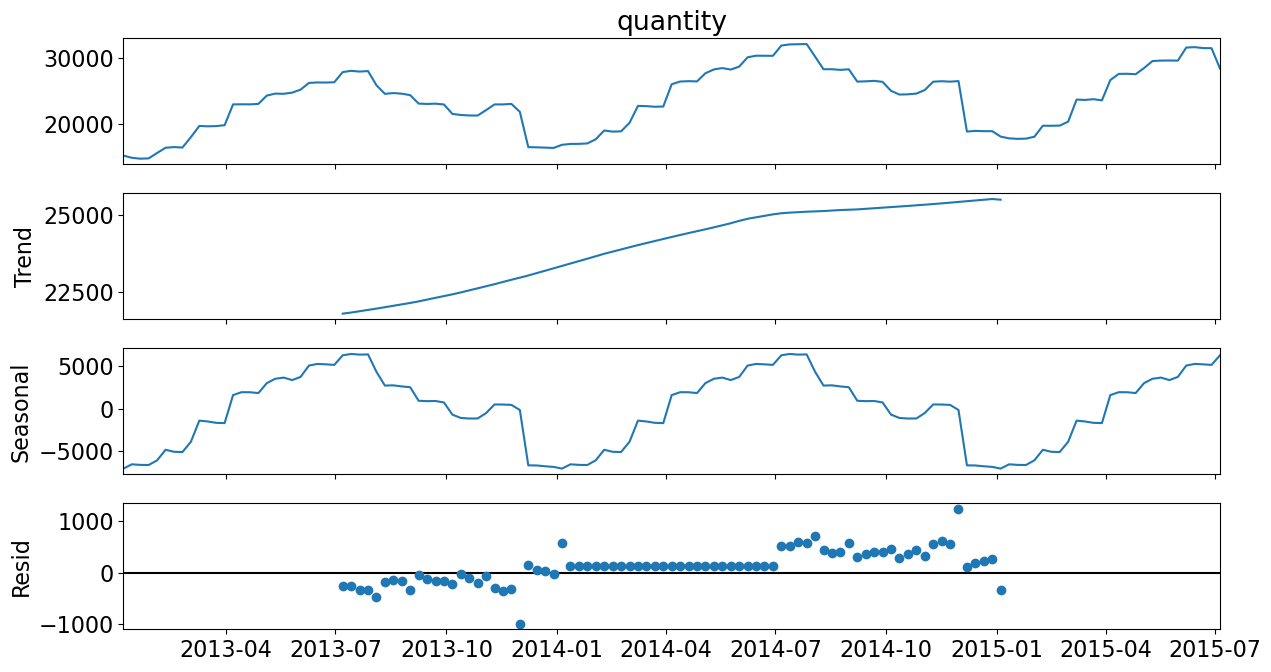

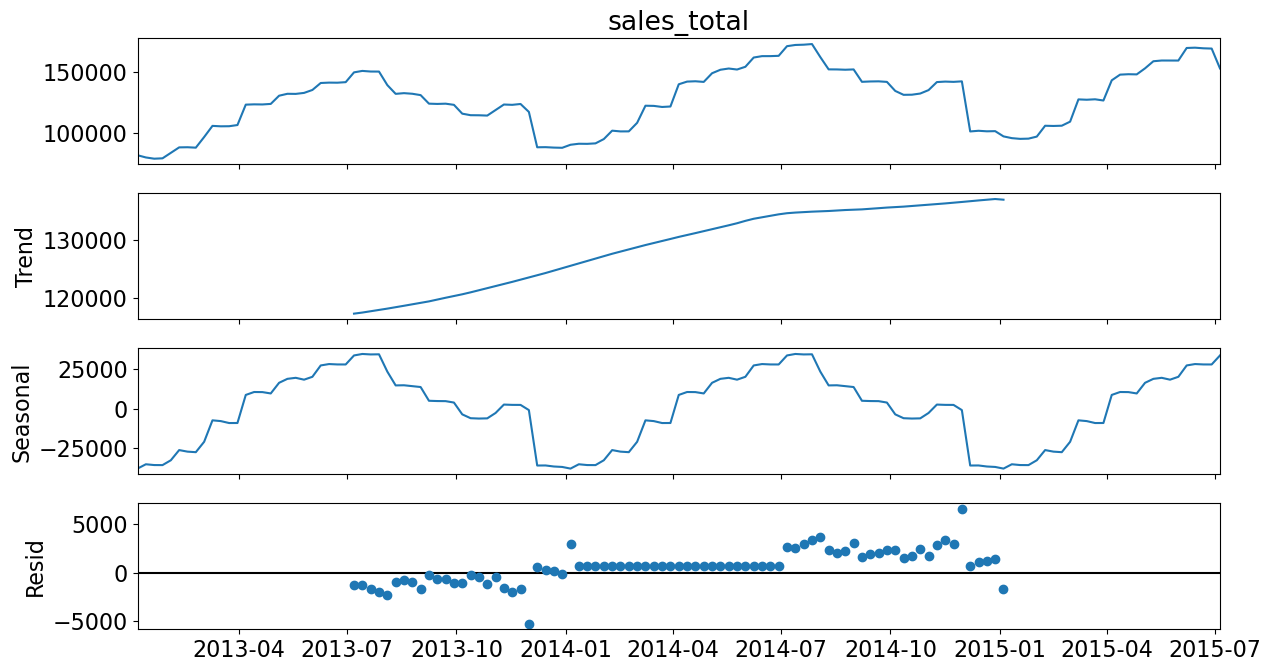

In [30]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()


In [31]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)


In [32]:
yhat_df.head()


,sales_total,quantity
sale_date,,
2015-07-02,170207.53,31656.49
2015-07-03,170328.01,31678.93
2015-07-04,170447.29,31701.15
2015-07-05,170565.37,31723.15
2015-07-06,170682.27,31744.93


quantity -- RMSE: 8225


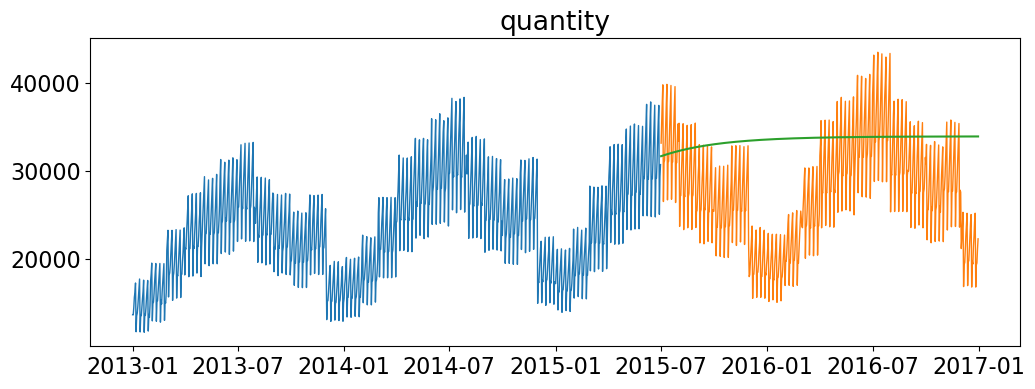

sales_total -- RMSE: 44226


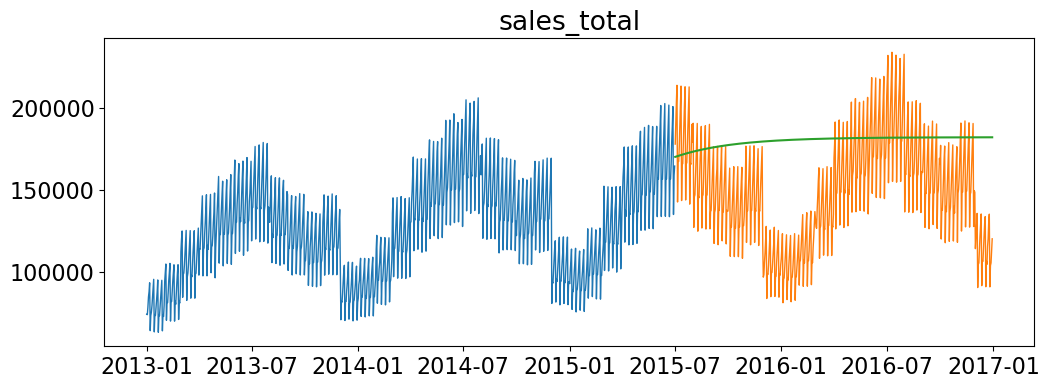

In [33]:
for col in train.columns:
    plot_and_eval(target_var = col)


In [34]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)


In [35]:
eval_df.sort_values(by='rmse')


,model_type,target_var,rmse
0,104_day_moving_avg,quantity,6101.0
0,52_day_moving_avg,quantity,6563.0
0,4_day_moving_avg,quantity,6592.0
0,last_observed_value,quantity,6621.0
0,30d moving average,quantity,6954.0
0,12_day_moving_avg,quantity,6992.0
0,26_day_moving_avg,quantity,7004.0
0,simple_average,quantity,7378.0
0,holts_optimized,quantity,8225.0
0,104_day_moving_avg,sales_total,32803.0


In [36]:
# Models for quantity
hst_quantity_fit1 = ExponentialSmoothing(train.quantity, seasonal_periods=365, trend='add', seasonal='add').fit()
hst_quantity_fit2 = ExponentialSmoothing(train.quantity, seasonal_periods=365, trend='add', seasonal='mul').fit()
hst_quantity_fit3 = ExponentialSmoothing(train.quantity, seasonal_periods=365, trend='add', seasonal='add', damped=True).fit()
hst_quantity_fit4 = ExponentialSmoothing(train.quantity, seasonal_periods=365, trend='add', seasonal='mul', damped=True).fit()

# Models for sales
hst_sales_fit1 = ExponentialSmoothing(train.sales_total, seasonal_periods=365, trend='add', seasonal='add').fit()
hst_sales_fit2 = ExponentialSmoothing(train.sales_total, seasonal_periods=365, trend='add', seasonal='mul').fit()
hst_sales_fit3 = ExponentialSmoothing(train.sales_total, seasonal_periods=365, trend='add', seasonal='add', damped=True).fit()
hst_sales_fit4 = ExponentialSmoothing(train.sales_total, seasonal_periods=365, trend='add', seasonal='mul', damped=True).fit()


In [37]:
results_quantity=pd.DataFrame({'model':['hst_quantity_fit1', 'hst_quantity_fit2', 'hst_quantity_fit3', 'hst_quantity_fit4'],
                              'SSE':[hst_quantity_fit1.sse, hst_quantity_fit2.sse, hst_quantity_fit3.sse, hst_quantity_fit4.sse]})
results_quantity.sort_values(by='SSE')


,model,SSE
0,hst_quantity_fit1,9.103219e+09
2,hst_quantity_fit3,9.103505e+09
3,hst_quantity_fit4,9.311315e+09
1,hst_quantity_fit2,9.349222e+09


In [38]:
results_sales=pd.DataFrame({'model':['hst_sales_fit1', 'hst_sales_fit2', 'hst_sales_fit3', 'hst_sales_fit4'],
                              'SSE':[hst_sales_fit1.sse, hst_sales_fit2.sse, hst_sales_fit3.sse, hst_sales_fit4.sse]})
results_sales.sort_values(by='SSE')


,model,SSE
0,hst_sales_fit1,2.625772e+11
2,hst_sales_fit3,2.625967e+11
3,hst_sales_fit4,2.686271e+11
1,hst_sales_fit2,2.697297e+11


In [39]:
results_sales=pd.DataFrame({'model':['hst_sales_fit1', 'hst_sales_fit2', 'hst_sales_fit3', 'hst_sales_fit4'],
                              'SSE':[hst_sales_fit1.sse, hst_sales_fit2.sse, hst_sales_fit3.sse, hst_sales_fit4.sse]})
results_sales.sort_values(by='SSE')


,model,SSE
0,hst_sales_fit1,2.625772e+11
2,hst_sales_fit3,2.625967e+11
3,hst_sales_fit4,2.686271e+11
1,hst_sales_fit2,2.697297e+11


In [40]:
yhat_df = pd.DataFrame({'sales_total': hst_sales_fit3.forecast(validate.shape[0] + 1),
                           'quantity': hst_quantity_fit3.forecast(validate.shape[0] + 1)},
                          index=validate.index)
yhat_df


,sales_total,quantity
sale_date,,
2015-07-02,164793.231438,30661.683007
2015-07-03,165858.970897,30851.258557
2015-07-04,175066.294116,32626.446070
2015-07-05,184537.887613,34436.542533
2015-07-06,195065.036678,36243.808664
...,...,...
2016-12-26,111795.794115,20720.813306
2016-12-27,118345.267126,22052.345517
2016-12-28,114838.550050,21310.901594


quantity -- RMSE: 5122


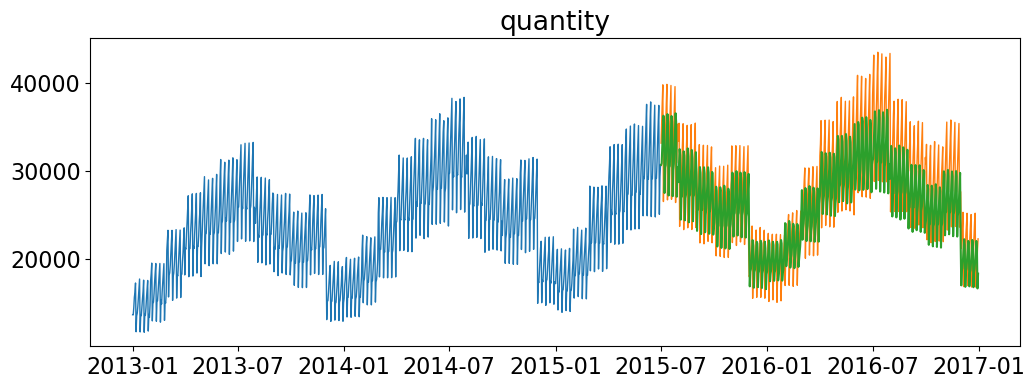

sales_total -- RMSE: 27546


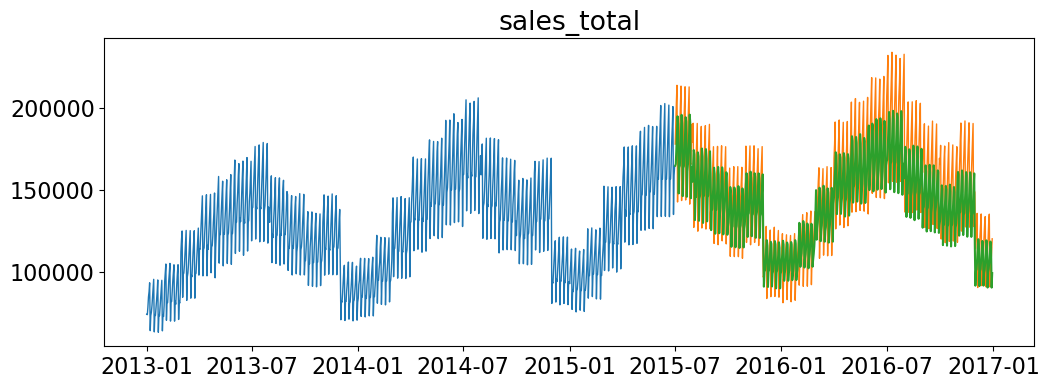

In [41]:
for col in train.columns:
    plot_and_eval(col)


In [42]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal', 
                            target_var = col)


In [43]:
eval_df.sort_values(by='rmse')


,model_type,target_var,rmse
0,holts_seasonal,quantity,5122.0
0,104_day_moving_avg,quantity,6101.0
0,52_day_moving_avg,quantity,6563.0
0,4_day_moving_avg,quantity,6592.0
0,last_observed_value,quantity,6621.0
0,30d moving average,quantity,6954.0
0,12_day_moving_avg,quantity,6992.0
0,26_day_moving_avg,quantity,7004.0
0,simple_average,quantity,7378.0
0,holts_optimized,quantity,8225.0


In [44]:
train = df_resampled.loc[:'2015']
validate = df_resampled.loc['2016']
test = df_resampled.loc['2017']


In [45]:
# find yoy diff. from 2013-2014 and 2014-2015, take the mean, and add to each value in 2015.
yhat_df = train.loc['2015'] + train.diff(365).mean()

# set yhat_df to index of validate
yhat_df.index = validate.index


In [46]:
yhat_df.head()


,quantity,sales_total
sale_date,,
2016-01-01,19411.813699,104337.620493
2016-01-02,20904.813699,112870.770493
2016-01-03,21983.813699,118245.300493
2016-01-04,23286.813699,125496.760493
2016-01-05,16420.813699,88551.940493


quantity -- RMSE: 5223


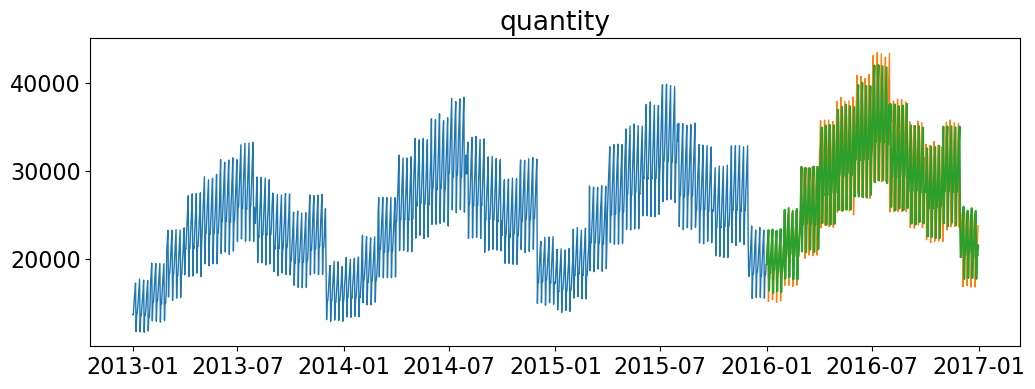

sales_total -- RMSE: 28087


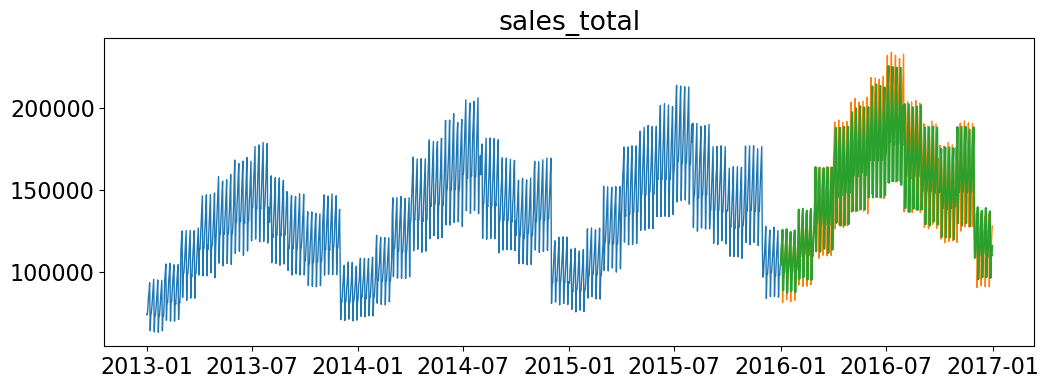

In [47]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)


In [48]:
eval_df.sort_values(by='rmse')


,model_type,target_var,rmse
0,holts_seasonal,quantity,5122.0
0,previous year,quantity,5223.0
0,104_day_moving_avg,quantity,6101.0
0,52_day_moving_avg,quantity,6563.0
0,4_day_moving_avg,quantity,6592.0
0,last_observed_value,quantity,6621.0
0,30d moving average,quantity,6954.0
0,12_day_moving_avg,quantity,6992.0
0,26_day_moving_avg,quantity,7004.0
0,simple_average,quantity,7378.0


In [49]:
sales_total_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

quantity_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == sales_total_min_rmse) | 
         (eval_df.rmse == quantity_min_rmse))]


,model_type,target_var,rmse
0,holts_seasonal,quantity,5122.0
0,holts_seasonal,sales_total,27546.0


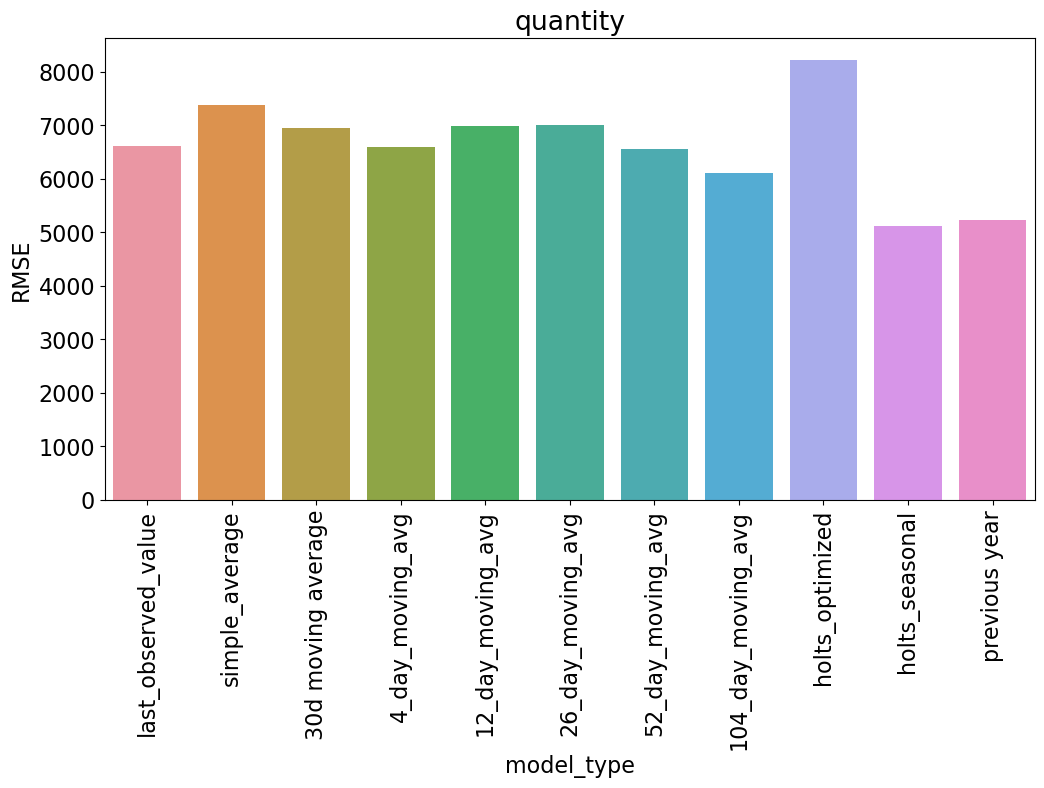

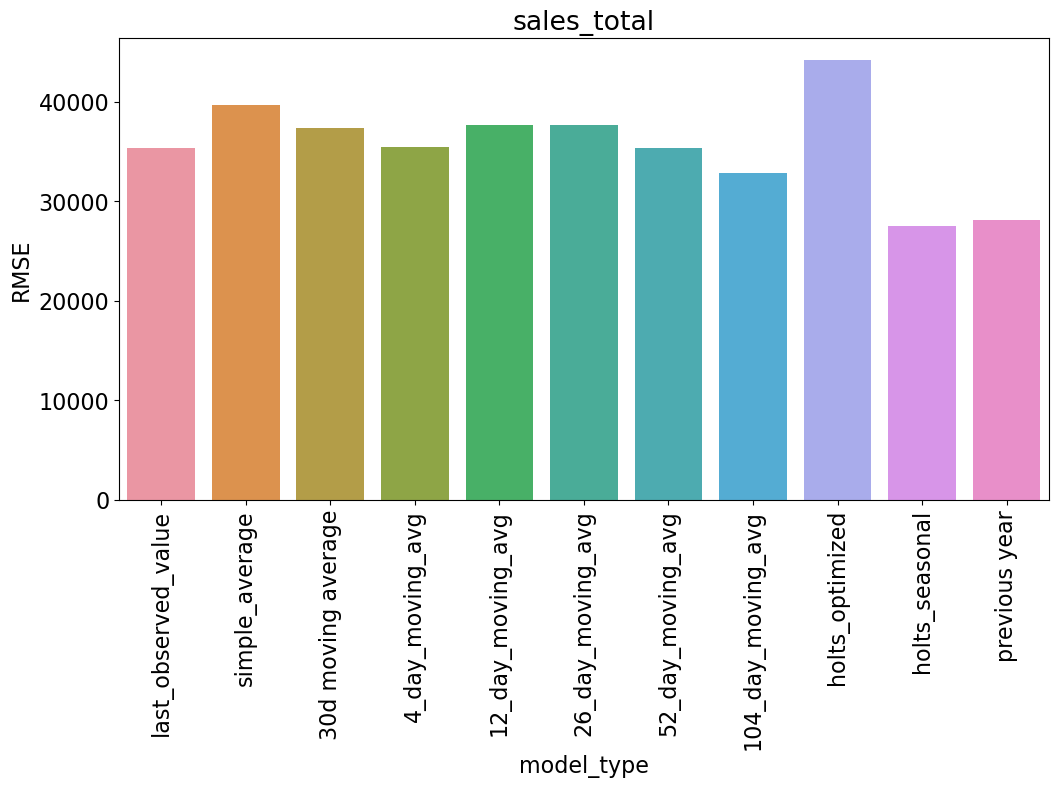

In [50]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x=x, y=y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=90)
    plt.show()


In [51]:
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]
train.shape, validate.shape, test.shape


((912, 2), (547, 2), (366, 2))

In [52]:
yhat_df = pd.DataFrame({'sales_total': hst_sales_fit3.forecast(validate.shape[0] + test.shape[0] + 1),
                           'quantity': hst_quantity_fit3.forecast(validate.shape[0] + test.shape[0] + 1)})
yhat_df


,sales_total,quantity
2015-07-02,164793.231438,30661.683007
2015-07-03,165858.970897,30851.258557
2015-07-04,175066.294116,32626.446070
2015-07-05,184537.887613,34436.542533
2015-07-06,195065.036678,36243.808664
...,...,...
2017-12-27,118356.816334,22054.469364
2017-12-28,114849.983765,21313.004202
2017-12-29,90159.077049,16676.672381
2017-12-30,99022.271553,18346.964584


In [53]:
yhat_df = yhat_df['2016-12-31':]


In [54]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(validate[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()


FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-sales total:  33377.76783892732
rmse-quantity:  6223.400534826063


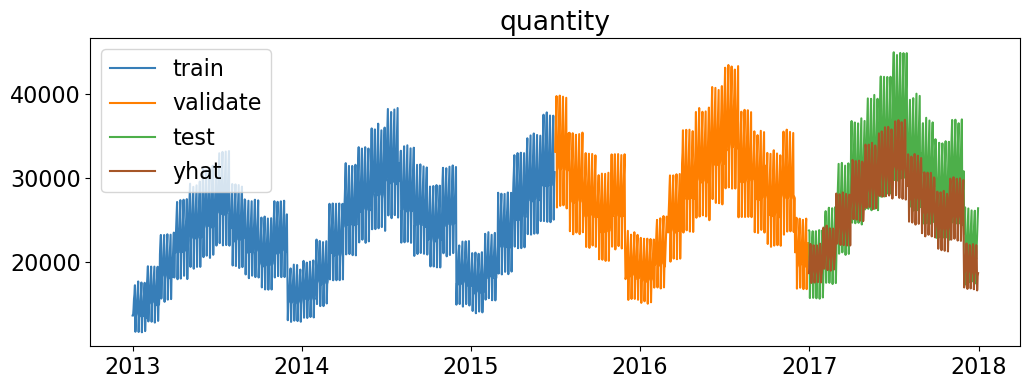

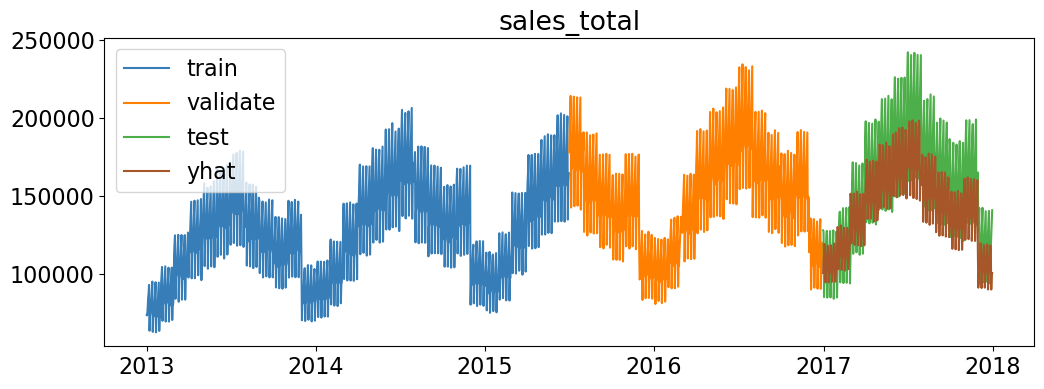

In [55]:
rmse_sales_total = sqrt(mean_squared_error(test['sales_total'], 
                                       yhat_df['sales_total']))

rmse_quantity = sqrt(mean_squared_error(test['quantity'], 
                                       yhat_df['quantity']))

print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-sales total: ', rmse_sales_total)
print('rmse-quantity: ', rmse_quantity)
for col in train.columns:
    final_plot(col)


In [56]:
# Forcasting Into Future
forecast = pd.DataFrame({'sales_total': hst_sales_fit3.forecast(validate.shape[0] + test.shape[0] + 1 + 365),
                           'quantity': hst_quantity_fit3.forecast(validate.shape[0] + test.shape[0] + 1 + 365)})
forecast = forecast['2018':]
forecast


,sales_total,quantity
2018-01-01,108073.898916,20026.313201
2018-01-02,111439.801091,20811.995153
2018-01-03,119265.375973,22192.540504
2018-01-04,116954.600818,21787.053687
2018-01-05,94734.021791,17565.698978
...,...,...
2018-12-27,118357.111046,22054.523560
2018-12-28,114850.275530,21313.057857
2018-12-29,90159.365896,16676.725499
2018-12-30,99022.557512,18347.017170


In [57]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='Train')
    plt.plot(validate[target_var], color='#ff7f00', label='Validate')
    plt.plot(test[target_var], color='#4daf4a', label='Test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.plot(forecast[target_var], color='#984ea3', label='Forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()


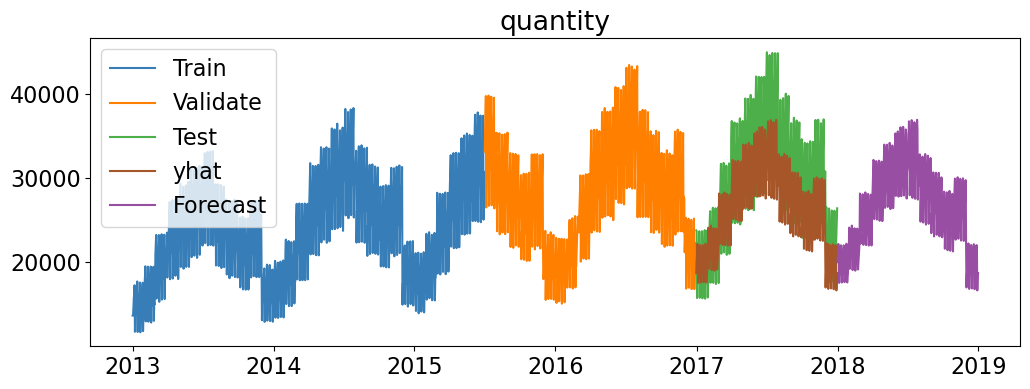

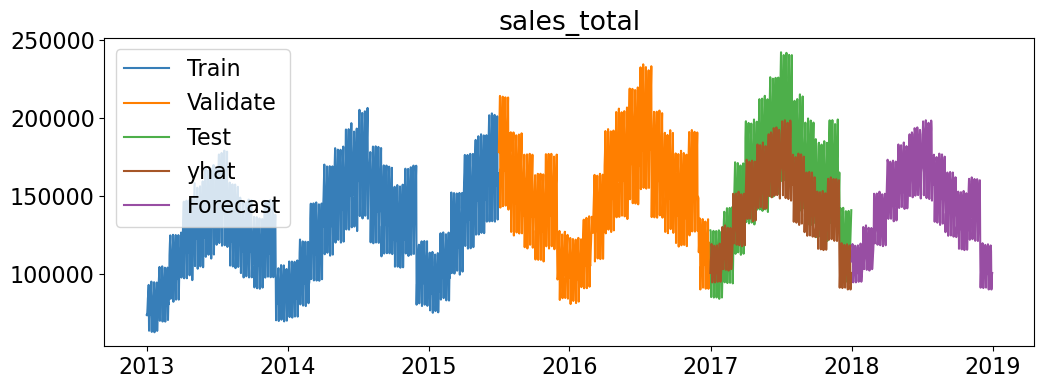

In [58]:
for col in train.columns:
    final_plot(col)


## Exercises

The end result of this exercise should be a Jupyter notebook named `model`.

Using saas.csv or log data from API usage

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.
2. Forecast, plot and evaluate using each at least 4 of the methods we discussed:
    - Last Observed Value
    - Simple Average
    - Moving Average
    - Holt's Linear Trend
    - Holt's Seasonal Trend
    - Based on previous year/month/etc., this is up to you.
- Bonus: 
1. Using the store item demand data, create a forecast of sales_total and quantity for 2018 using the Previous Cycle approach. .
2. Predict 2018 total **monthly** sales for a single store and/or item by creating a model using prophet. 
3. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper). 
4. Plot the 2018 monthly sales predictions.

In [59]:
# Load dataset
df = pd.read_csv('saas.csv')
df.head(3)

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [63]:
df.Customer_Id.nunique()

29400

In [66]:
def prep_saas_data(df):
    '''
    Prepares raw SaaS data for analysis and time series modeling.
    '''
    # Lowercase column names
    df.columns = df.columns.str.lower()
    
    # Rename columns
    df = df.rename(columns={'month_invoiced': 'date_invoice'})
    
    # Convert invoice date to datetime format
    df.date_invoice = pd.to_datetime(df.date_invoice)
    
    # Set invoice date as index and sort by index
    df = df.set_index('date_invoice').sort_index()
    
    return df


In [68]:
df_resampled = prep_saas_data(df)

In [69]:
train_size = int(len(df_resampled) * .7)
validate_size = int(len(df_resampled) * .25)
test_size = int(len(df_resampled) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df_resampled[: train_size]
validate = df_resampled[train_size : validate_end_index]
test = df_resampled[validate_end_index : ]


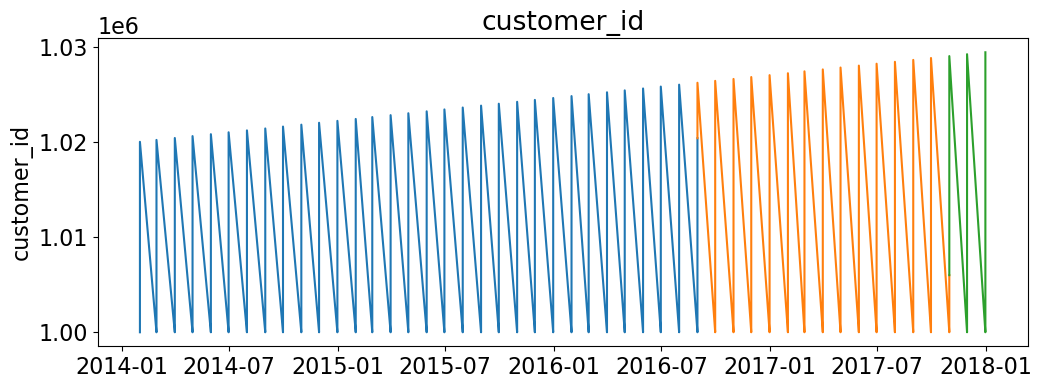

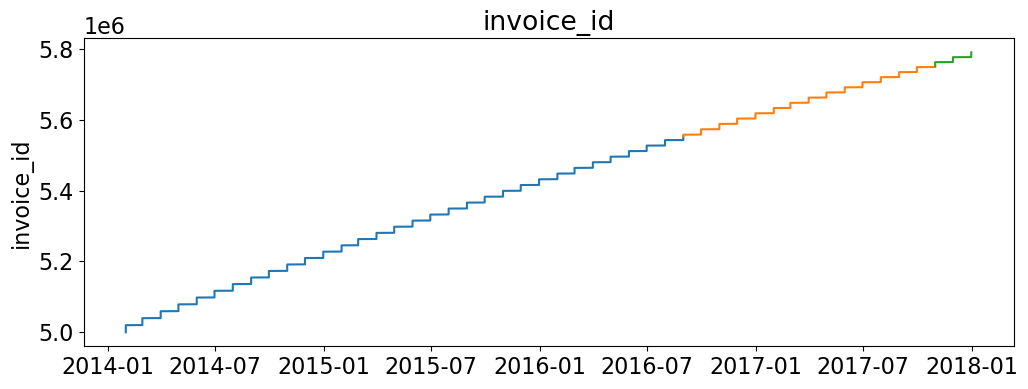

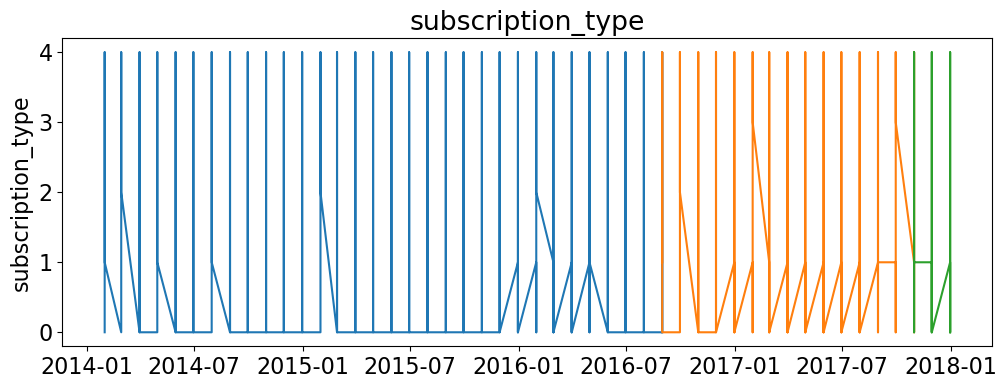

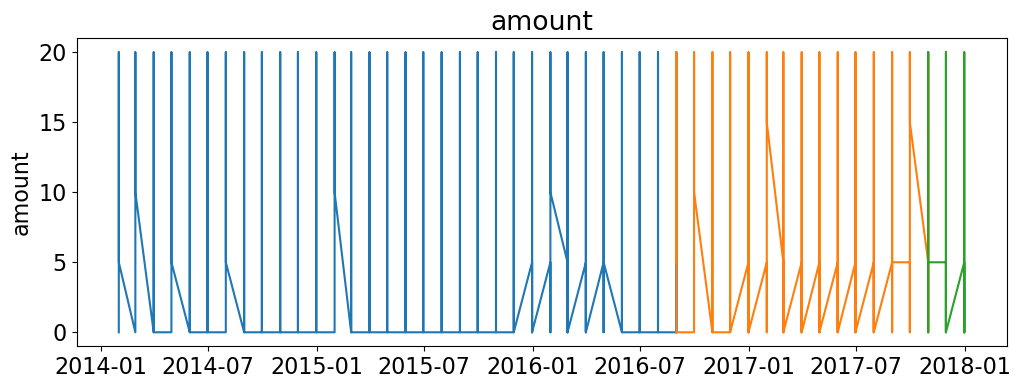

In [70]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()


In [71]:
# evaluation function to compute rmse
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


In [72]:
# plot and evaluate 
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()


In [73]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df


,model_type,target_var,rmse


In [74]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return pd.concat([eval_df, d])


In [75]:
# take the last item of sales total and assign to variable
last_amount = train['amount'][-1:][0]

yhat_df = pd.DataFrame(
    {'amount': [last_sales]},
    index=validate.index)

yhat_df.head()


,amount
date_invoice,
2016-08-31,164573.2
2016-08-31,164573.2
2016-08-31,164573.2
2016-08-31,164573.2
2016-08-31,164573.2


In [78]:
eval_df


,model_type,target_var,rmse


In [79]:
# compute simple average of sales_total (from train data)
avg_amount = round(train['amount'].mean(), 2)

yhat_df = pd.DataFrame({'sales_total': [avg_sales]},
                        index=validate.index)

yhat_df.head(3)


,sales_total
date_invoice,
2016-08-31,127517.85
2016-08-31,127517.85
2016-08-31,127517.85


In [81]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30

rolling_sales = round(train['amount'].rolling(period).mean()[-1], 2)

# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'amount': rolling_sales},
                         index=validate.index)
yhat_df.head()


,amount
date_invoice,
2016-08-31,2.0
2016-08-31,2.0
2016-08-31,2.0
2016-08-31,2.0
2016-08-31,2.0


In [82]:
periods = [7, 15, 30, 150, 365]

for p in periods: 
    rolling_sales = round(train['amount'].rolling(p).mean()[-1], 2)
    
    yhat_df = pd.DataFrame({'sales_total': rolling_sales},
                            index=validate.index)
    model_type = str(p) + '_day_moving_avg'
